Лабораторная работа 6.

Исследование эффективности методов классификации с помощью статистического моделирования.

Цель: исследовать статистические свойства эмпирического риска, оценки скользящего экзамена и вероятности ошибочной классификации на синтезированных данных.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from functools import reduce

!pip install mlxtend --upgrade
from mlxtend.evaluate import bias_variance_decomp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


1. Придумать двумерную вероятностную модель для двух классов. Это может быть смесь нормальных распределений (с различными параметрами) с числом компонент, большим чем число классов.


In [ ]:
features_num = 4

mean1, sigma1 = [0, 0, 0, 0], [0.1, 0.5, 0.7, 0.3] # mean, standard deviation of 1 class
mean2, sigma2 = [0.3, 0.2, 0.4, -0.2], [0.3, 0.4, 0.5, 0.4] # mean, standard deviation of 2 class


def getFrame(n_class1, n_class2):
  frame = pd.DataFrame()

  first_class = np.random.normal(loc = mean1, scale = sigma1, size=[n_class1, features_num])
  second_class = np.random.normal(loc = mean2, scale = sigma2, size=[n_class2, features_num])

  frame['target'] = np.concatenate((np.full(first_class.shape[0], 0), np.full(second_class.shape[0], 1)))
  frame['f1'] = np.concatenate((first_class[:,0], second_class[:,0]))
  frame['f2'] = np.concatenate((first_class[:,1], second_class[:,1]))
  frame['f3'] = np.concatenate((first_class[:,2], second_class[:,2]))
  frame['f4'] = np.concatenate((first_class[:,3], second_class[:,3]))

  return frame

frame = getFrame(100, 250)

print(frame)

     target        f1        f2        f3        f4
0         0  0.016489  0.091052 -0.038204  0.219881
1         0  0.099040  0.855799 -1.336619  0.083275
2         0 -0.071077 -1.081275 -0.026928  0.089929
3         0 -0.032724 -0.255363  0.430703  0.373931
4         0  0.132020 -0.812918  0.274349 -0.046352
..      ...       ...       ...       ...       ...
345       1  0.802160  0.283614  0.105609  0.016215
346       1  0.278460  0.587479 -0.221411 -0.373800
347       1  0.522815  0.142330  0.534931 -0.588076
348       1  0.850406  0.471406 -0.291036  0.594682
349       1  0.512360  0.038616  0.162161  0.026302

[350 rows x 5 columns]


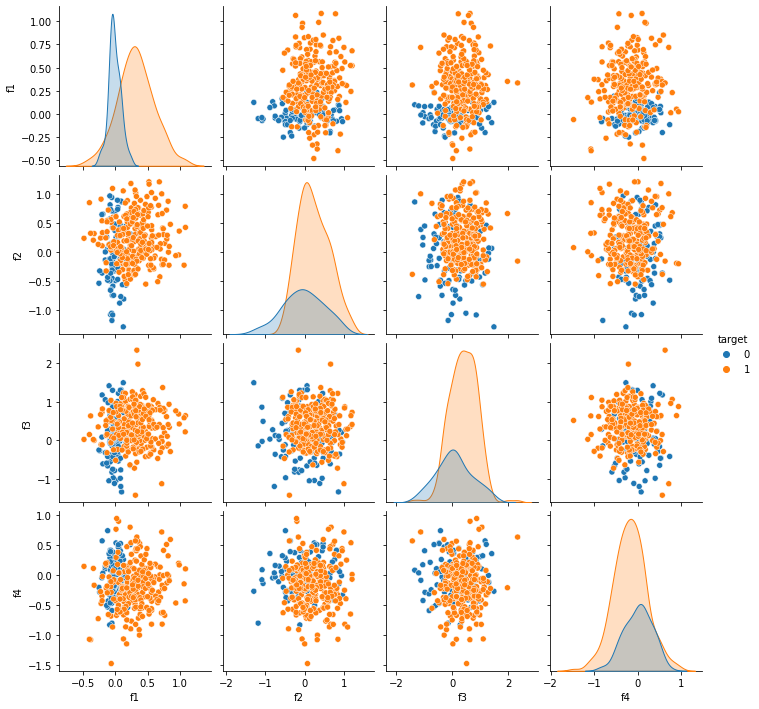

In [ ]:
sns.pairplot(frame, hue = 'target')

2. Задать параметры: размер обучающей выборки (порядка 100 объектов), число разбиений кроссвалидации. Выбрать метод классификации и задать его параметры.


In [ ]:
n_splits = 5

clf = [GradientBoostingClassifier(n_estimators=10, learning_rate=1.0, max_depth=1, random_state=0),
       DecisionTreeClassifier(random_state=42, max_depth=2),
       LinearDiscriminantAnalysis(),
       QuadraticDiscriminantAnalysis(),
       LogisticRegression(random_state=0),
       SVC(kernel='linear', C=1.0)]

3. Повторять шаги 4–7 заданное число раз (50–100).
4. Сгенерировать обучающую выборку заданного размера.
5. Построить решающую функцию. Вычислить эмпирический риск (число ошибок на обучении).
6. Сгенерировать контрольную выборку достаточно большого размера (больше 10000 объектов). Вычислить оценку вероятности ошибочной классификации.
7. Вычислить оценку вероятности ошибочной классификации методом скользящего экзамена (на исходной обучающей выборке).


    dataset_idx  empirical_risk  error_probability  control_dataset_er_prob
0           0.0           0.105              0.205                   0.1603
1           1.0           0.075              0.150                   0.1648
2           2.0           0.060              0.150                   0.1787
3           3.0           0.110              0.255                   0.1808
4           4.0           0.095              0.190                   0.1770
..          ...             ...                ...                      ...
95         95.0           0.115              0.190                   0.1756
96         96.0           0.105              0.220                   0.1679
97         97.0           0.095              0.230                   0.1864
98         98.0           0.090              0.280                   0.1660
99         99.0           0.115              0.235                   0.1851

[100 rows x 4 columns]


<function matplotlib.pyplot.show(*args, **kw)>

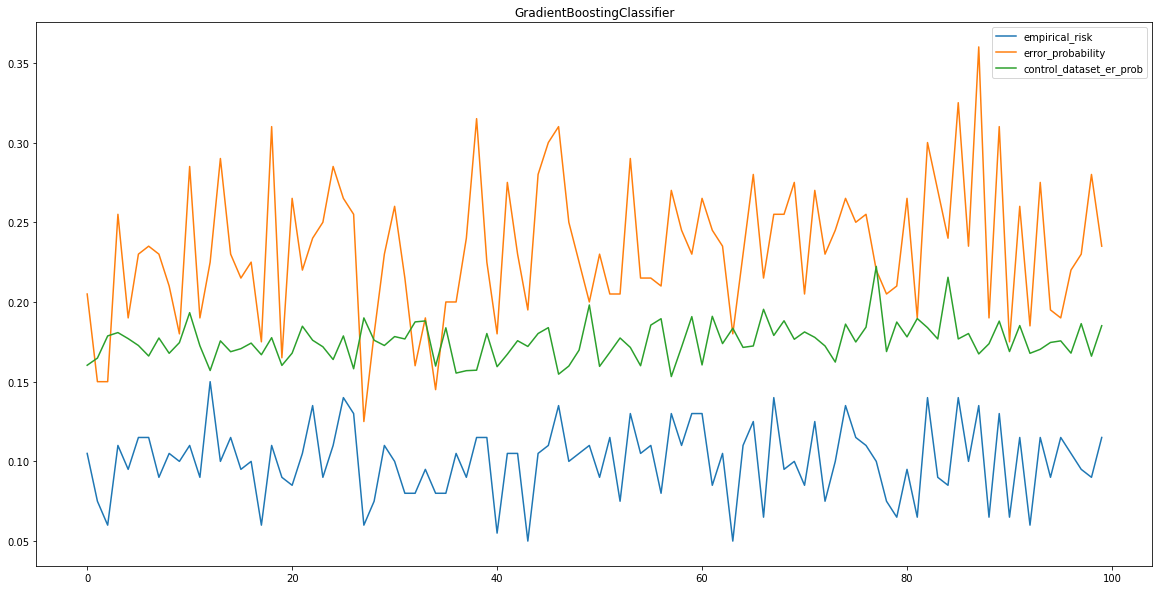

In [ ]:
def countErrors(prediction, groundtrue):
  mistakes = 0
  for pr, gt in zip(prediction, groundtrue):
    if pr != gt:
      mistakes += 1
  return mistakes

def experiment(model):
  number_of_experiments = 100

  experiment_result = pd.DataFrame()
  experiment_result['dataset_idx'] = np.zeros(number_of_experiments)
  experiment_result['empirical_risk'] = np.zeros(number_of_experiments)
  experiment_result['error_probability'] = np.zeros(number_of_experiments)
  experiment_result['control_dataset_er_prob'] = np.zeros(number_of_experiments)

  for i in range(number_of_experiments):
    frame = getFrame(100, 100)
    experiment_result['dataset_idx'][i] = i

    X = frame.iloc[:,[1,2,3,4]]
    y = frame.target

    model = model.fit(X, y)
    predict = model.predict(X)

    mistakes = countErrors(predict, y)
    experiment_result['empirical_risk'][i] = mistakes / len(predict)

    mistakes = []
    kf = KFold(n_splits=n_splits, shuffle=False)
    for train_index, test_index in kf.split(y):
      X_train_sub = np.take(X, train_index, axis=0)
      X_test_sub = np.take(X, test_index, axis=0)
      y_train_sub = np.take(y, train_index)
      y_test_sub = np.take(y, test_index)
      model = model.fit(X_train_sub, y_train_sub)
      predict = model.predict(X_test_sub)
      mistakes.append(countErrors(predict, y_test_sub) / len(predict))

    experiment_result['error_probability'][i] = np.mean(mistakes)

    frame = getFrame(100, 100)
    X = frame.iloc[:,[1,2,3,4]]
    y = frame.target
    model = model.fit(X, y)

    frame = getFrame(5000, 5000)
    X = frame.iloc[:,[1,2,3,4]]
    y = frame.target
    predict = model.predict(X)

    mistakes = countErrors(predict, y)
    experiment_result['control_dataset_er_prob'][i] = mistakes / len(predict)

  return experiment_result

model = clf[0]
experiment_result = experiment(model)
print(experiment_result)

plt.title(type(model).__name__)
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(experiment_result["dataset_idx"], experiment_result["empirical_risk"])
plt.plot(experiment_result["dataset_idx"], experiment_result["error_probability"])
plt.plot(experiment_result["dataset_idx"], experiment_result["control_dataset_er_prob"])
plt.legend(('empirical_risk', 'error_probability', 'control_dataset_er_prob'), loc='upper right')
plt.show

Авторское замечание!: в данном блоке мы подводим итог об эффективности и объективности различных матрик успешности классификатора. Очевидно, что валидация на обучающей выборке (empirical_risk) - плохая идея т.к. переобучение может сильно снизить значение данной метрики (модель запоминает только обучающие данные). Из графика четко видно, что эмпирический риск (валидация по train_data) показывает наименьшее среднее значение. Кроме того, справедливо заметить, что валидация на большой выборке объективных синтетических данных (control_dataset) - отличная идея т.к. показывает действительное положение вещей. Такую метрику меньше всего отклоняет из эксперимента в эксперимент т.к. такая метрика показывает исключительно эффективность обученной модели. К сожалению, в реальных задачах такой выборки нет т.к. реальные задачи не основываются на синтетических данных. В то же время метрика кросс энтропией показывает среднее значение выше значение метрики объективных данных (это можно объяснить тем, что количество данных в обуч. кросс энтропии меньше ровно на величину тестовой выборки, в данной работе 80/20 т.е. модель обучалась на 80% данных, в отличии от 100% объективных данных), но все же кросс энтропия показывает значения ближе к истинным, чем верификация по обучающим данным.

9. Вычислить средние и стандартные отклонения по каждому столбцу.



In [ ]:
def analys(experiment_result):
  experiment_analys = pd.DataFrame()
  experiment_analys['metric'] = ['Среднее', 'стандартное отколонение']
  experiment_analys['risk'] = [ np.mean(experiment_result.iloc[:,1]) , np.std(experiment_result.iloc[:,1])]
  experiment_analys['cross_entropy'] = [ np.mean(experiment_result.iloc[:,2]) , np.std(experiment_result.iloc[:,2])]
  experiment_analys['ground_true'] = [ np.mean(experiment_result.iloc[:,3]) , np.std(experiment_result.iloc[:,3])]
  return experiment_analys

experiment_analys = analys(experiment_result)
print(experiment_analys)

                    metric      risk  cross_entropy  ground_true
0                  Среднее  0.103550       0.239800     0.172491
1  стандартное отколонение  0.019096       0.036776     0.010618


10. Провести аналогичное моделирование, изменив вероятностную модель, или метод классификации, или параметры метода.
11. Сделать выводы, насколько выбранный метод классификации и его параметры соответствуют сложности модели и объёму выборки.


In [ ]:
models_statistic = pd.DataFrame()
models_statistic['classifier'] = np.zeros(len(clf))
models_statistic['mean_risk'] = np.zeros(len(clf))
models_statistic['sd_risk'] = np.zeros(len(clf))
models_statistic['mean_cross_entropy'] = np.zeros(len(clf))
models_statistic['sd_cross_entropy'] = np.zeros(len(clf))
models_statistic['mean_ground_error'] = np.zeros(len(clf))
models_statistic['sd_ground_error'] = np.zeros(len(clf))

for i, model in enumerate(clf):
  experiment_result = experiment(model)
  experiment_analys = analys(experiment_result)
  models_statistic.loc[i, "classifier"] = type(model).__name__
  models_statistic.loc[i,"mean_risk"] = experiment_analys['risk'][0]
  models_statistic.loc[i,"sd_risk"] = experiment_analys['risk'][1]
  models_statistic.loc[i,"mean_cross_entropy"] = experiment_analys['cross_entropy'][0]
  models_statistic.loc[i,"sd_cross_entropy"] = experiment_analys['cross_entropy'][1]
  models_statistic.loc[i,"mean_ground_error"] = experiment_analys['ground_true'][0]
  models_statistic.loc[i,"sd_ground_error"] = experiment_analys['ground_true'][1]

print(models_statistic)

                      classifier  mean_risk   sd_risk  mean_cross_entropy  \
0     GradientBoostingClassifier    0.10075  0.019741             0.23320   
1         DecisionTreeClassifier    0.15510  0.028522             0.28190   
2     LinearDiscriminantAnalysis    0.18565  0.028711             0.28855   
3  QuadraticDiscriminantAnalysis    0.13460  0.025910             0.20180   
4             LogisticRegression    0.19325  0.028243             0.32800   
5                            SVC    0.18155  0.030510             0.31105   

   sd_cross_entropy  mean_ground_error  sd_ground_error  
0          0.039532           0.173022         0.010873  
1          0.082106           0.192992         0.017030  
2          0.047087           0.190293         0.009563  
3          0.033746           0.149164         0.004975  
4          0.042691           0.201222         0.011730  
5          0.051475           0.189864         0.011927  


Выведу средние значение трех метрик для каждого классификатора из выборки.

Авторское замечание!: 

В данном блоке мы наслаждаемся сравнением средних значений метрик для разных классификаторов. Коротко напомню логику каждого классификатора:

DecisionTree - образует дерево принятие решений на основании пороговых значений признаков (т.е. на каждой ветке выбирается наиболее информативный признак и наиболее эффективное пороговое значение, разделяющее классы).

GradientBoosting: ансамбль дерьевьев, каждое из которых обучается на основании результата предидущего (уточняя результат). Является одним из самых эффективных методов решения многих задач.

QDA: Классификатор, предполагающий, что функции условной плотности вероятности классов являются Гауссовыми. Учитывая, что данные изначально в нормальном распределении, можно сказать, что задача будет довольно простой для данного классификатора. Предполагается, что данный классификатор справится лучше всего.

LDA: модификация QDA, использующее упрощающее предположение о том, что кофариации разных классов идентичны. Не должен сильно уступать QDA.

Лог регрессия - модель оценивающая данные путем сравнения с лог. кривой. Умные люди говорят, что результат должен быть схож с LDA.

SVC - классический метод опорных векторов, да еще и с линейным ядром. Вообще то не самый эффективный метод, но наши данные не имеют сложных распределений (т.е. один класс не обволакивает другой и т.д.) так что имеет все шансы показать результат, но не должен быть самым успешным.



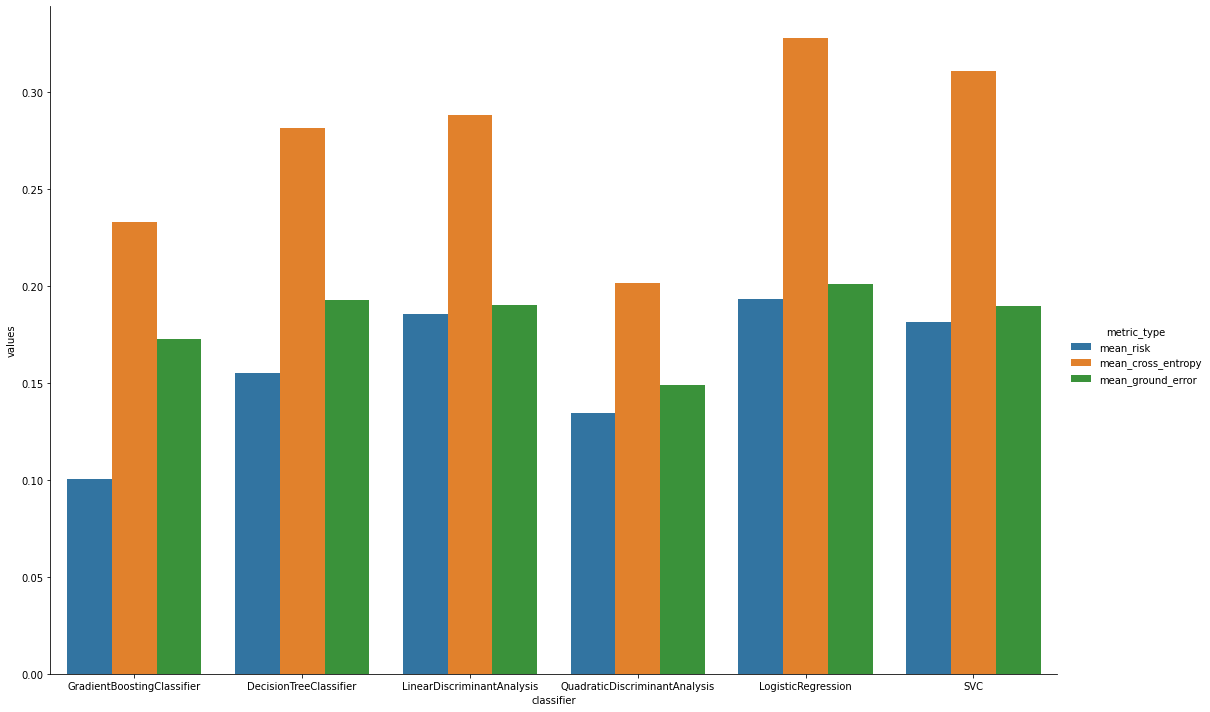

In [ ]:
def draw_barplot(x, y, data):
  df = data[[x]+y].melt(id_vars=[x], value_name='values', var_name='metric_type')
  sns.catplot(data=df, x=x, y='values', hue='metric_type', kind="bar", height=10, aspect=1.5)


draw_barplot("classifier", ["mean_risk", "mean_cross_entropy", "mean_ground_error"], models_statistic)

Авторское замечание!: 

DecisionTree: отличный представитель любителя переобучиться. Имеет одну из самых высоких ошибок генеральной выборки, при относительно малом значении ошибки на обучающих данных.

Градиентный бустинг: по финальному результату кросс валидации и генеральной выборки уступает только QDA т.е. прекрасно справился с задачей, но  умудрился переобучиться больше всех.

LDA, лог регрессия и svc показали очень схожие результаты. Занятно, что они практически не способны к переобучению т.к. оценка эмпирического риска почти сравнялась с генеральной метрикой.

QDA имеет меньше все ошибок как на генеральной выборке, так и на кросс валидации. Объяснить очень просто, ведь данная задача буквально его родная среда. Мы попросили оценить нормальные данные нормальным распределением...


Выведу стандартное отклонение трех метрик для каждого классификатора из выборки.

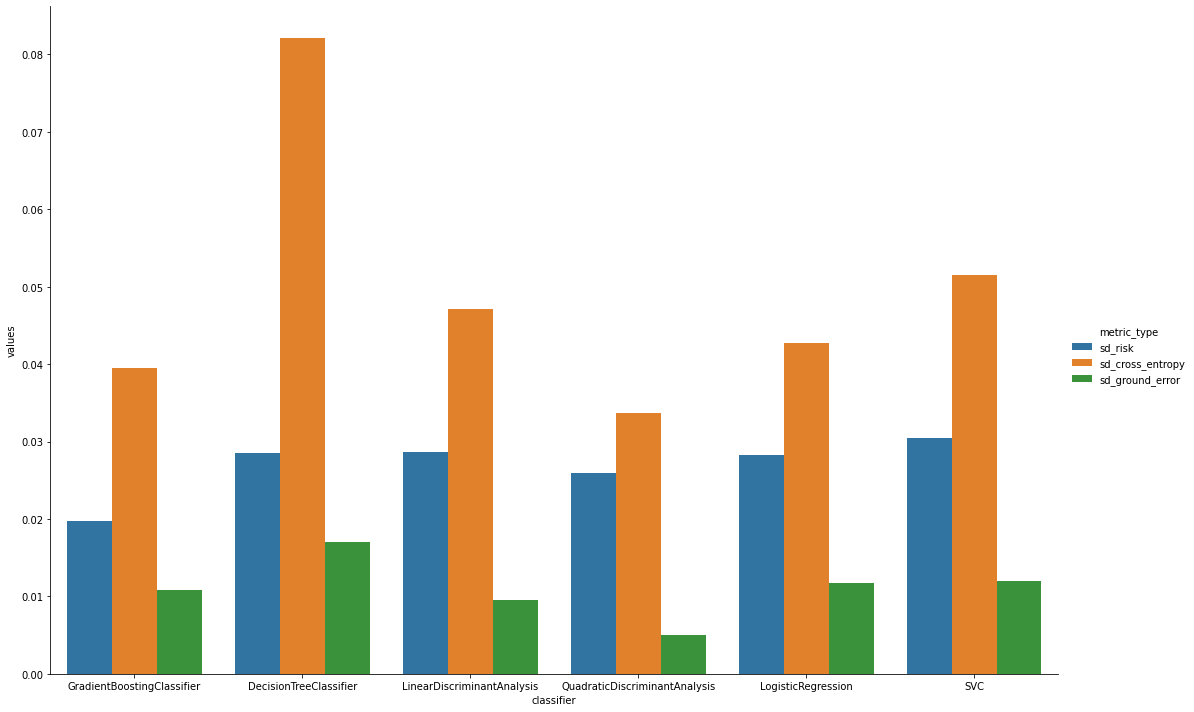

In [ ]:
draw_barplot("classifier", ["sd_risk", "sd_cross_entropy", "sd_ground_error"], models_statistic)

Авторское замечание!: 

standart_deviation показывает нестабильность классификаторов от определенных запусков. Видно, что обучающее дерево сильно зависит от удачности выборки и соответственно имеет большой разброс кросс валидации и генеральной метрики. При этом разброс тренировочной метрики не слишком велик т.к. дерево все такие прекасно запоминает обучающие данные.

12. Факультативно: вычислить смещение и разброс (bias-variance decomposition).

In [ ]:
def experiment_bias_variance(models):
  models_statistic = pd.DataFrame()
  models_statistic['classifier'] = np.zeros(len(clf))
  models_statistic['bias_risk'] = np.zeros(len(clf))
  models_statistic['variance_risk'] = np.zeros(len(clf))
  models_statistic['bias_cross_entropy'] = np.zeros(len(clf))
  models_statistic['variance_cross_entropy'] = np.zeros(len(clf))
  models_statistic['bias_ground_error'] = np.zeros(len(clf))
  models_statistic['variance_ground_error'] = np.zeros(len(clf))


  for i, model in enumerate(models):
    models_statistic.loc[i, "classifier"] = type(model).__name__

    frame = getFrame(100, 100)

    X = frame.iloc[:,[1,2,3,4]]
    y = frame.target

    mse, bias, variance = bias_variance_decomp(model, X.values, y.values, X.values, y.values, loss='mse', random_seed=42)

    models_statistic.loc[i, "bias_risk"] = bias
    models_statistic.loc[i, "variance_risk"] = variance

    biases = []
    variances = []
    kf = KFold(n_splits=n_splits, shuffle=False)
    for train_index, test_index in kf.split(y):
      X_train_sub = np.take(X, train_index, axis=0)
      X_test_sub = np.take(X, test_index, axis=0)
      y_train_sub = np.take(y, train_index)
      y_test_sub = np.take(y, test_index)

      mse, bias, variance = bias_variance_decomp(model, X_train_sub.values, y_train_sub.values, X_test_sub.values, y_test_sub.values, loss='mse', random_seed=42)
      biases.append(bias)
      variances.append(variance)

    models_statistic.loc[i, "bias_cross_entropy"] = np.mean(biases)
    models_statistic.loc[i, "variance_cross_entropy"] = np.mean(variances)

    frame = getFrame(100, 100)
    X = frame.iloc[:,[1,2,3,4]]
    y = frame.target

    frame = getFrame(5000, 5000)
    X_test = frame.iloc[:,[1,2,3,4]]
    y_test = frame.target

    mse, bias, variance = bias_variance_decomp(model, X.values, y.values, X_test.values, y_test.values, loss='mse', random_seed=42)

    models_statistic.loc[i, "bias_ground_error"] = bias
    models_statistic.loc[i, "variance_ground_error"] = variance

  return models_statistic

model_statistic = experiment_bias_variance(clf)
print(model_statistic)

                      classifier  bias_risk  variance_risk  \
0     GradientBoostingClassifier   0.073781       0.043269   
1         DecisionTreeClassifier   0.078617       0.041308   
2     LinearDiscriminantAnalysis   0.172935       0.036515   
3  QuadraticDiscriminantAnalysis   0.131392       0.026183   
4             LogisticRegression   0.143127       0.033148   
5                            SVC   0.120841       0.035184   

   bias_cross_entropy  variance_cross_entropy  bias_ground_error  \
0            0.157186                0.072363           0.116527   
1            0.130890                0.065735           0.157295   
2            0.266141                0.048059           0.176280   
3            0.187809                0.038916           0.124757   
4            0.252172                0.049103           0.170322   
5            0.216010                0.048789           0.165036   

   variance_ground_error  
0               0.065294  
1               0.062048  
2      

Авторское замечание!: 

Bias — это ошибка из-за ошибочных предположений в алгоритме обучения . Высокое смещение может привести к тому, что алгоритм упустит соответствующие отношения между функциями и целевыми выходными данными (недообучение).

Variance — это ошибка от чувствительности к небольшим колебаниям обучающей выборки . Высокая дисперсия может быть результатом алгоритма, моделирующего случайный шум в обучающих данных ( переобучение ).

Модели sklearn обучаются до определенного момента (пока не посчитают себя обученными достаточно), а значит по данным bias variance значениям мы можем судить о финальной недообученности или переобученности модели. Модели с большим значением variance более склонны к переобучению ввиду особенностей модели или объективной глубины модели (например ввиду большого количества внутренних слоев или параметров). В то же время модели с большим bias наоборот могут считаться более глупыми и склонными к недообучению (не имеющими возможность запомнить много).

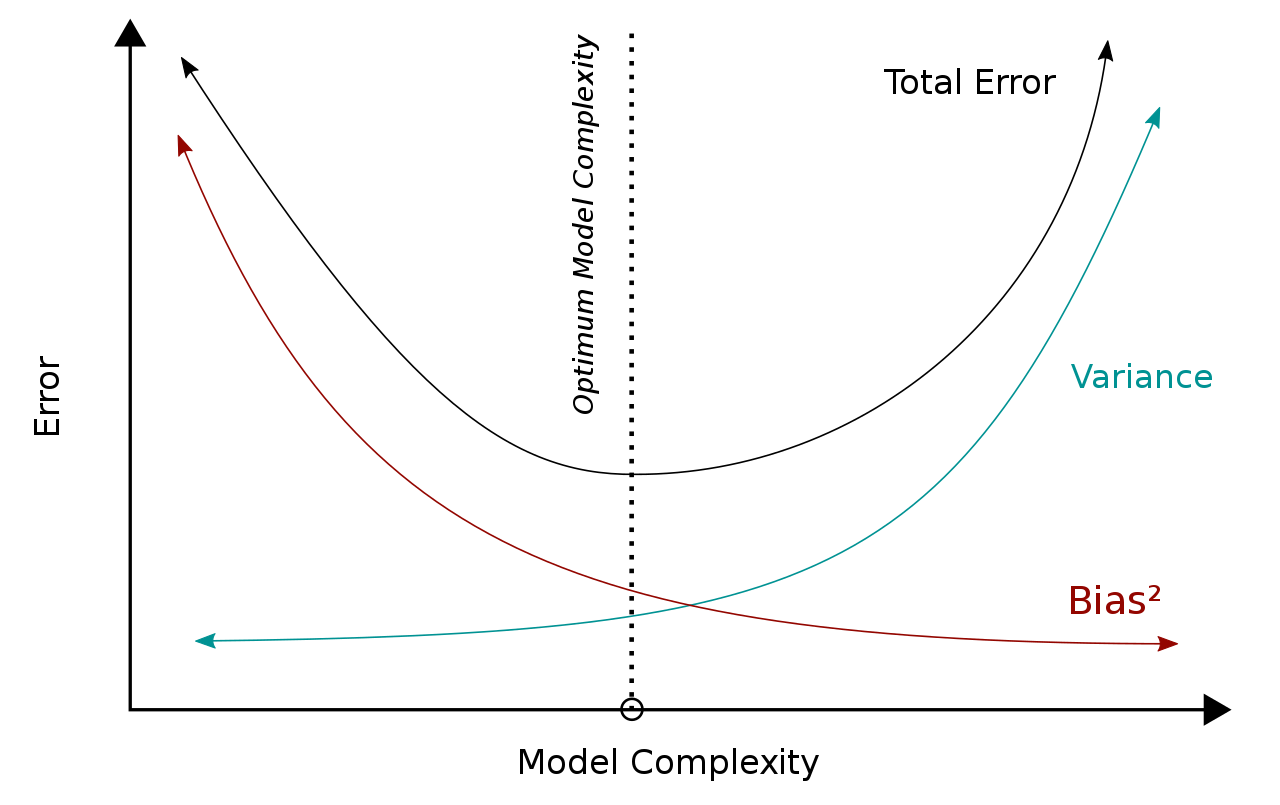

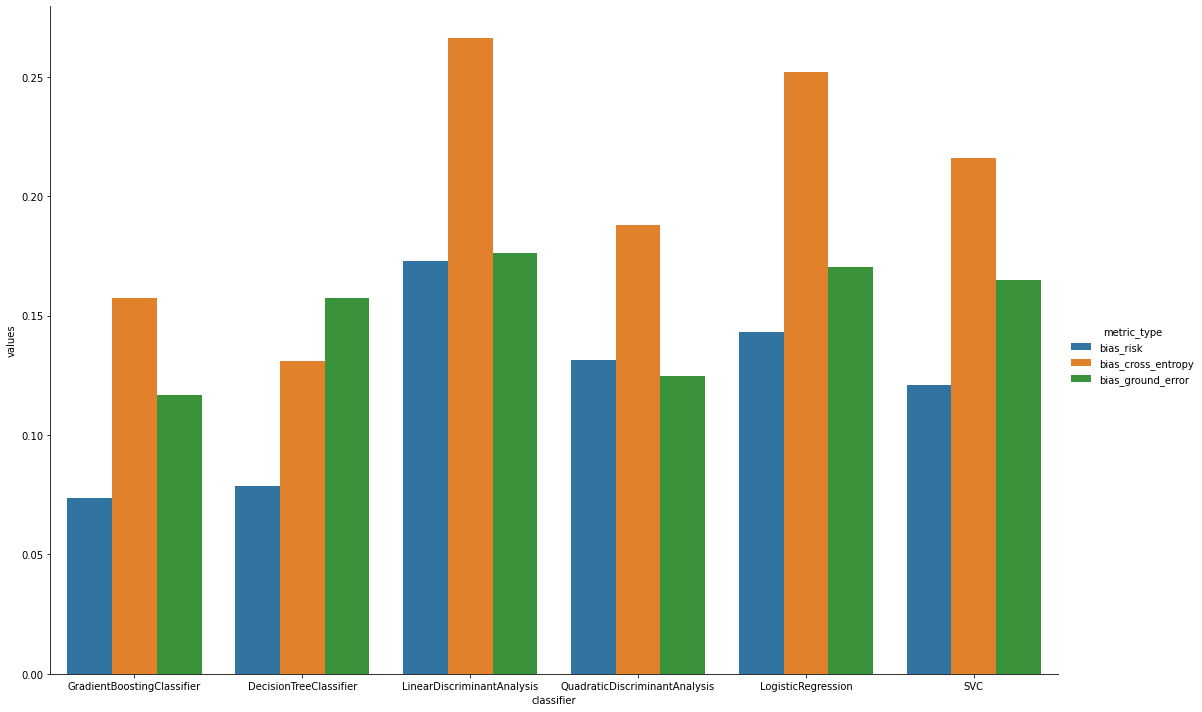

In [ ]:
draw_barplot("classifier", ["bias_risk", "bias_cross_entropy", "bias_ground_error"], model_statistic)

Авторское замечание!:

Bias обоих деревьев на тренировочной выборке сильно меньше всех, что доказывает, что им не свойственно недообучаться. Они способны масштабировать свою сложность. Остальные модели показывают +- один результат (QDA слегка выделяется т.к. имеет возможность быстрого сведение к нужному результату)

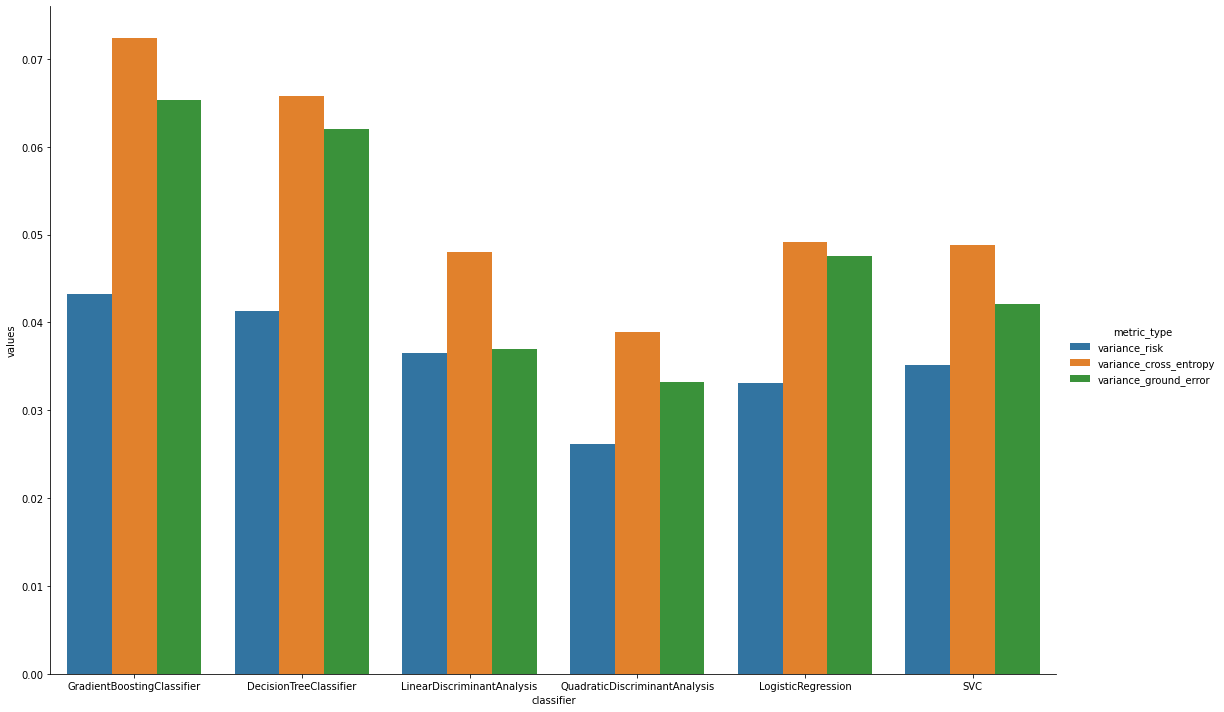

In [ ]:
draw_barplot("classifier", ["variance_risk", "variance_cross_entropy", "variance_ground_error"], model_statistic)

Авторское замечание!:

Variance у деревьев наибольший (очевидно). Qda показывает, что он практически не имеет возможности переобучиться. Забавно то, как сильно значение variance эмпирического риска отстает от значений других метрик. Это легко объяснить тем, что трудно оценить степень переобучения, когда тренировочные и тестовые данные совпадают. 